# Anupama Kadambi


# Netflix movie recommendation system

**Installing surprise library**

In [ ]:
# Installing surprise library
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.8 MB 12.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1633721 sha256=4d1075701198e33847ceabf6b7f39886b39599e970c4a136fa32b37b891e31f7
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [ ]:
# Used to ignore the warning given as output of the code
import warnings                                 
warnings.filterwarnings('ignore')

# Basic libraries of python for numeric and dataframe computations
import numpy as np                              
import pandas as pd

# Basic library for data visualization
import matplotlib.pyplot as plt     

# Slightly advanced library for data visualization            
import seaborn as sns                           

# A dictionary output that does not raise a key error
from collections import defaultdict             

# A performance metrics in surprise
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [ ]:
# Import the dataset
rating = pd.read_csv('/content/ratings.csv')
#rating = pd.read_csv('/content/drive/MyDrive/ratings.csv') # Uncomment this line code  and comment above line of code if you are using google colab.

In [ ]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


- There are **1,00,004 observations** and **4 columns** in the data
- All the columns are of **numeric data type**
- The data type of the timestamp column is int64 which is not correct. We can convert this to DateTime format but **we don't need timestamp for our analysis**. Hence, **we can drop this column**

In [ ]:
# Dropping timestamp column
rating = rating.drop(['timestamp'], axis=1)

##  Exploring the dataset (7 Marks)**

Let's explore the dataset and answer some basic data-related questions:

###**Q 1.1 Print the top 5 rows of the dataset (1 Mark)**

In [ ]:
# Printing the top 5 rows of the dataset Hint: use .head()


rating.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


In [ ]:
rating.index.name="rate"

In [ ]:
rating.head()

,userId,movieId,rating
rate,,,
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


###  Describe the distribution of ratings



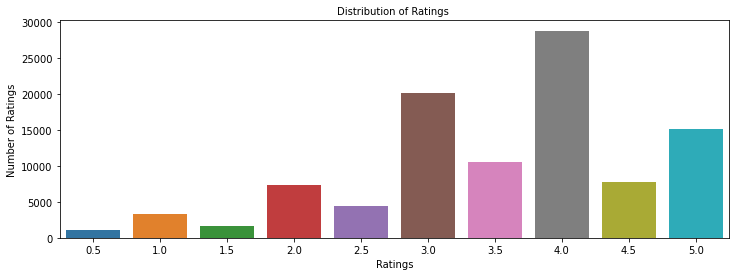

In [ ]:
plt.figure(figsize = (12, 4))


sns.countplot(x="rating", data = rating)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

From the graph most of the movies have maximum number of ratings as 3 or 4 with few being 5. Also people tend to give whole number ratings as opposed to fractions.The number of 1 star ratings are surpisingly low.

###  total number of unique users and unique movies


In [ ]:
# Finding number of unique users

rating['userId'].nunique()

671

There are 671 unique userIDs

In [ ]:
# Finding number of unique movies


rating['movieId'].nunique()

9066

There are 671 unique userIDs and 9066 unique movieIDs.

# movie that has been interacted with more than once by the same user

In [218]:
rating.groupby(['userId', 'movieId']).count()

rating
userId movieId        
1      31            1
       1029          1
       1061          1
       1129          1
       1172          1
...                ...
671    6268          1
       6269          1
       6365          1
       6385          1
       6565          1

[100004 rows x 1 columns]

In [ ]:
rating.groupby(['userId', 'movieId']).count()['rating'].sum()

100004

No there are not.

### most interacted movie in the dataset

In [ ]:

rating['movieId'].mode()

0    356
dtype: int64

movie ID 356 is most interacted with.

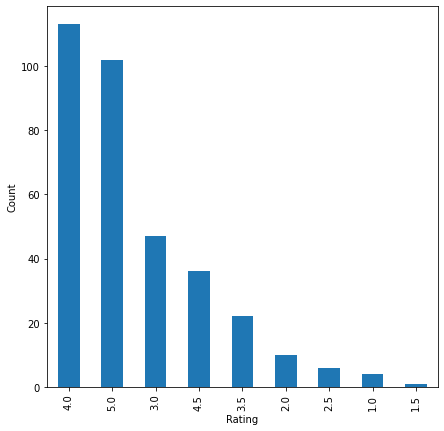

In [ ]:
# Plotting distributions of ratings for 341 interactions with movieid 356 
plt.figure(figsize=(7,7))

rating[rating['movieId'] == 356]['rating'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

Most popular rating for 356 is 4.0 or 5.0 suggesting its a good movie.

###  Which user interacted the most with any movie in the dataset

In [ ]:

rating['userId'].mode()

0    547
dtype: int64

User 547 interacted the most.

###  distribution of the user-movie interactions in this dataset

In [ ]:
# Finding user-movie interactions distribution
count_interactions = rating.groupby('userId').count()['movieId']
count_interactions = pd.DataFrame(count_interactions)

In [ ]:
count_interactions

,movieId
userId,
1,20
2,76
3,51
4,204
5,100
...,...
667,68
668,20
669,37


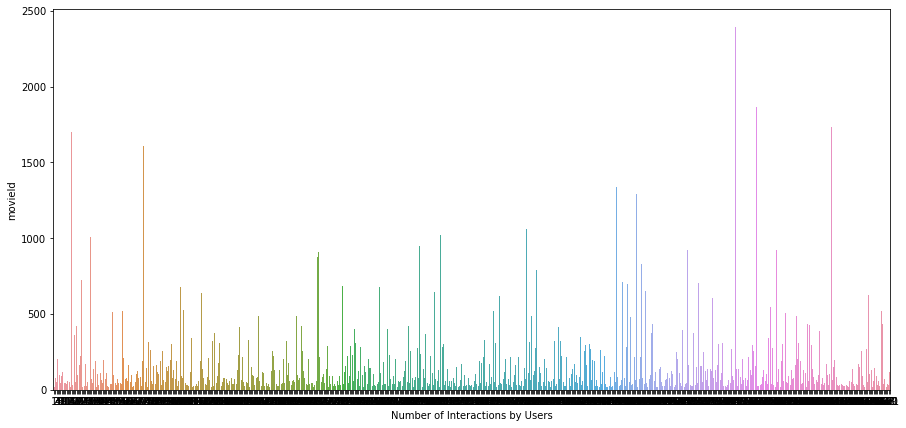

In [ ]:
# Plotting user-movie interactions distribution

plt.figure(figsize=(15,7))


sns.barplot(x = count_interactions.index, y = 'movieId', data = count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()

In [1]:
from pandas._libs import index


# Calculating average ratings
average_rating = rating.groupby('movieId').mean()['rating']
# Calculating the count of ratings
count_rating = rating.groupby('movieId').count()['rating']

# Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

NameError: name 'rating' is not defined

In [ ]:
def top_n_movies(data, n, min_interaction=100):
    
    #Finding movies with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

#### **Recommending top 5 movies with 50 minimum interactions based on popularity**

In [ ]:

list(top_n_movies(final_rating, 5, 50))

[858, 318, 913, 1221, 50]

#### **Recommending top 5 movies with 100 minimum interactions based on popularity**

In [ ]:

list(top_n_movies(final_rating, 5, 100))

#### **Recommending top 5 movies with 200 minimum interactions based on popularity**

In [ ]:

list(top_n_movies(final_rating, 5, 200))

[318, 50, 527, 608, 296]

## User based Collaborative Filtering Recommendation System (7 Marks)**

#### **Making the dataset into surprise dataset and splitting it into train and test set**

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#### **Build the first baseline similarity based recommendation system using cosine similarity and KNN**

In [ ]:

sim_options = {'name': 'cosine',
               'user_based': True}
# Defining Nearest neighbour algorithm
algo_knn_user = KNNBasic(sim_options=sim_options, verbose=False, random_state=1)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_user.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_user.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9925


0.9924509041520163

### RMSE for baseline user based collaborative filtering recommendation system

the RMSE is 0.9925

###  Predicted  rating for an user with userId=4 and for movieId=10 and movieId=3

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [ ]:

algo_knn_user.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.62   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.6244912065910952, details={'actual_k': 40, 'was_impossible': False})

Actual value is 4 and the predicted value is 3.62.

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [ ]:

algo_knn_user.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.20   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.202703552548654, details={'actual_k': 40, 'was_impossible': False})

Presicted value is 3.2

### hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system

In [219]:


# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30, 40], 'min_k': [1, 3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}}

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.990477589818506
{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters** as shown above.

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [ ]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.009305,1.009377,0.992483,1.003722,0.007947,41,0.776842,0.779570,0.767211,0.774541,0.005301,21,0.458771,0.100685,2.037277,0.151807,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': True, 'min_su..."
1,1.008258,1.006793,0.990995,1.002015,0.007816,36,0.776032,0.777761,0.766514,0.773436,0.004945,15,0.322762,0.018189,1.925258,0.088032,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': True, 'min_su..."
2,1.015242,1.013627,0.998581,1.009150,0.007503,49,0.789392,0.789958,0.778124,0.785825,0.005450,50,0.694189,0.035806,1.921812,0.104738,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson', 'user_based': True, 'min_s..."
3,1.012002,1.010341,0.996549,1.006297,0.006926,44,0.785996,0.787486,0.776928,0.783470,0.004666,47,0.569497,0.041497,1.960170,0.016929,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson', 'user_based': True, 'min_s..."
4,1.003379,1.005572,0.992735,1.000562,0.005607,28,0.778871,0.781070,0.772353,0.777431,0.003702,32,0.593775,0.045851,1.841756,0.063850,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson_baseline', 'user_based': Tru..."


Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.



In [220]:
# Remove _______ and complete the code
sim_options = {'name': 'cosine',
               'user_based': True, "min_support":2}
# Using the optimal similarity measure for user-user based collaborative filtering
# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_user = KNNBasic(sim_options=sim_options, k=40, min_k=3, random_state=1, verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_user.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_user.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9864


0.9863841021026428

The tuned model has lower RMSE  of 0.9864than untuned. This is not normal and somethng seems to be wrong.

###  Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using tuned user based collaborative filtering

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [ ]:

similarity_algo_optimized_user.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.58   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.583535324429299, details={'actual_k': 30, 'was_impossible': False})

The predicted value is 3.58

Below we are predicting rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model as shown below - 

In [ ]:

similarity_algo_optimized_user.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.17   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.170232402310352, details={'actual_k': 30, 'was_impossible': False})



```
# This is formatted as code
```

Predicted value is 3.17

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [ ]:
similarity_algo_optimized_user.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of movies we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has not interacted yet
    non_interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has not interacted yet
    for item_id in non_interacted_movies:
        
        # Predicting the ratings for those non interacted movie ids by this user
        est = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating movies for this user

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [183]:

recommendations = get_recommendations(rating,4,5,similarity_algo_optimized_user)


### **Q 3.5 Predict the top 5 movies for userId=4 with similarity based recommendation system (1 Mark)**

In [184]:
recommendations

[(309, 5),
 (3038, 4.999999999999999),
 (98491, 4.899347045407786),
 (6273, 4.839859025263867),
 (116, 4.753206589295344)]

## **Model 3: Item based Collaborative Filtering Recommendation System (7 Marks)**

In [186]:


# Definfing similarity measure
sim_options = {'name': 'pearson',
               'user_based': False}

# Defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options, random_state=1,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

# Predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 0.9964


0.9964454065946875

###  RMSE for baseline item based collaborative filtering recommendation system 

Baseline RMSE is 0.9964


Let's us now predict rating for an user with `userId=4` and for `movieId=10`

###  Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3

In [187]:

algo_knn_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 4.42   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=4.420788161822849, details={'actual_k': 40, 'was_impossible': False})

Actual value is 4 but predicted value is 4.42

Let's predict  the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`

In [188]:

algo_knn_item.predict(4,3, verbose=True)

user: 4          item: 3          r_ui = None   est = 4.06   {'actual_k': 40, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=4.064635736744944, details={'actual_k': 40, 'was_impossible': False})

Predicted value is 4.06

###  hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system

In [195]:
# Remove _______ and complete the code

# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30], 'min_k': [3, 6, 9],
              'sim_options': {'name': ["cosine",'pearson',"pearson_baseline"],
                              'user_based': [True], "min_support":[2,4]}
              }

# Performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting the data
grid_obj.fit(data)

# Best RMSE score
print(grid_obj.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

0.9890892930352312
{'k': 30, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True, 'min_support': 2}}


Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above**

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [196]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.000903,0.999442,1.005759,1.002034,0.002700,41,0.772660,0.771323,0.775801,0.773261,0.001877,22,0.525770,0.084572,2.449167,0.230022,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': True, 'min_su..."
1,0.998822,0.997340,1.003524,0.999895,0.002636,32,0.770960,0.770805,0.774308,0.772024,0.001616,16,0.382686,0.034630,1.937707,0.082052,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'cosine', 'user_based': True, 'min_su..."
2,1.004742,1.004215,1.012997,1.007318,0.004022,48,0.782213,0.781798,0.786502,0.783504,0.002126,49,0.753067,0.102216,2.163621,0.087867,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson', 'user_based': True, 'min_s..."
3,1.001892,1.001410,1.008123,1.003809,0.003057,44,0.779687,0.780421,0.782703,0.780937,0.001284,47,0.601676,0.084826,1.933184,0.067787,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson', 'user_based': True, 'min_s..."
4,0.992912,0.995870,1.004120,0.997634,0.004743,25,0.772688,0.774814,0.779428,0.775643,0.002813,32,0.608080,0.036825,1.924697,0.032768,"{'k': 10, 'min_k': 3, 'sim_options': {'name': ...",10,3,"{'name': 'pearson_baseline', 'user_based': Tru..."


Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

In [197]:

# Creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options= {'name': 'cosine', 'user_based': True, 'min_support': 2} , k= 30, min_k= 3,verbose=False)

# Training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)

# Predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

# Computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 0.9871


0.9871266024277001

The RMSE is 0.9871

### **Q 4.4 What is the Predicted rating for an item with userId =4 and for movieId= 10 and movieId=3 using tuned item based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model as shown below

In [198]:

similarity_algo_optimized_item.predict(4,10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.58   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.583535324429299, details={'actual_k': 30, 'was_impossible': False})

The actual value is 4 and predicted value is 3.58

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`, by using the optimized model:

In [199]:

similarity_algo_optimized_item.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.17   {'actual_k': 30, 'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.170232402310352, details={'actual_k': 30, 'was_impossible': False})

Predicted value is 3.17

### **Identifying similar users to a given user (nearest neighbors)**
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=4` based on the `msd` distance metric

In [200]:
# Remove _______ and complete the code
similarity_algo_optimized_item.get_neighbors(4, k=5)

[357, 220, 590, 491, 647]

#### **Predicted top 5 movies for userId=4 with similarity based recommendation system**

In [201]:
# Remove _______ and complete the code
recommendations = get_recommendations(rating, 4, 5, similarity_algo_optimized_item)

###  Predict the top 5 movies for userId=4 with similarity based recommendation system 

In [202]:
recommendations

[(309, 5),
 (3038, 4.999999999999999),
 (98491, 4.899347045407786),
 (6273, 4.839859025263867),
 (116, 4.753206589295344)]

## Based Collaborative Filtering - Matrix Factorization using SVD (7 Marks)**

### **Build a baseline matrix factorization recommendation system**

In [203]:


# Using SVD matrix factorization
algo_svd = SVD(random_state=1)

# Training the algorithm on the trainset
algo_svd.fit(trainset)

# Predicting ratings for the testset
predictions = algo_svd.test(testset)

# Computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9054


0.9054387709175701

###  RMSE for baseline SVD based collaborative filtering recommendation system

Baseline RMSE is 0.9054

###  Predicted  rating for an user with userId =4 and for movieId= 10 and movieId=3

Let's us now predict rating for an user with `userId=4` and for `movieId=10`

In [204]:

algo_svd.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.91   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.9077426421450028, details={'was_impossible': False})

The predicted value is 3.91

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [205]:

algo_svd.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.78   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.783481116986586, details={'was_impossible': False})

The predicted value is 3.78

### **Improving matrix factorization based recommendation system by tuning its hyper-parameters**

In [206]:
# Remove _______ and complete the code

# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

# Fitting data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

0.8927922375675247
{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


In [207]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head()

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,0.941997,0.941609,0.945179,0.942928,0.001599,25,0.737347,0.736469,0.739753,0.737856,0.001388,25,3.159225,0.188989,0.502757,0.029728,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,0.946240,0.945673,0.949427,0.947113,0.001652,26,0.742717,0.741178,0.744378,0.742758,0.001307,26,3.073341,0.138219,0.581231,0.044535,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,0.951831,0.951258,0.954442,0.952510,0.001386,27,0.748568,0.747324,0.749853,0.748582,0.001033,27,2.864742,0.102699,0.524527,0.085995,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6
3,0.905805,0.905164,0.907833,0.906267,0.001138,11,0.701966,0.701192,0.703073,0.702077,0.000772,9,2.985581,0.070947,0.510804,0.011544,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.2}",10,0.005,0.2
4,0.912769,0.911790,0.915128,0.913229,0.001401,15,0.709371,0.708457,0.710851,0.709560,0.000987,15,3.128452,0.118643,0.532260,0.070717,"{'n_epochs': 10, 'lr_all': 0.005, 'reg_all': 0.4}",10,0.005,0.4


In [208]:
# Remove _______ and complete the code

# Building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs= 30 , lr_all= 0.01 , reg_all= 0.2)

# Training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# Predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# Computing RMSE
accuracy.rmse(predictions)

RMSE: 0.8952


0.8951763486412249

### **Q 5.4 What is the Predicted rating for an user with userId =4 and for movieId= 10 and movieId=3 using SVD based collaborative filtering? (1 Mark)**

Let's us now predict rating for an user with `userId=4` and for `movieId=10` with the optimized model

In [209]:

svd_algo_optimized.predict(4, 10, r_ui=4, verbose=True)

user: 4          item: 10         r_ui = 4.00   est = 3.98   {'was_impossible': False}


Prediction(uid=4, iid=10, r_ui=4, est=3.976896254984367, details={'was_impossible': False})

Predicted value is 3.98

Let's predict the rating for the same `userId=4` but for a movie which this user has not interacted before i.e. `movieId=3`:

In [210]:

svd_algo_optimized.predict(4, 3, verbose=True)

user: 4          item: 3          r_ui = None   est = 3.62   {'was_impossible': False}


Prediction(uid=4, iid=3, r_ui=None, est=3.6172388765057426, details={'was_impossible': False})

### Predict the top 5 movies for userId=4 with SVD based recommendation system

In [211]:
# Remove _______ and complete the code
get_recommendations(rating, 4, 5, svd_algo_optimized)

[(116, 4.973847985875436),
 (5114, 4.96889001924208),
 (1192, 4.962194215769075),
 (926, 4.945114544200765),
 (1948, 4.917126351810015)]

### **Predicting ratings for already interacted movies** 

In [212]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # Creating an empty list to store the recommended movie ids
    recommendations = []
    
    # Creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='userId', columns='movieId', values='rating')
    
    # Extracting those movie ids which the user_id has interacted already
    interacted_movies = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # Looping through each of the movie id which user_id has interacted already
    for item_id in interacted_movies:
        
        # Extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, item_id]
        
        # Predicting the ratings for those non interacted movie ids by this user
        predicted_rating = algo.predict(user_id, item_id).est
        
        # Appending the predicted ratings
        recommendations.append((item_id, actual_rating, predicted_rating))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['movieId', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating movies for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=7`

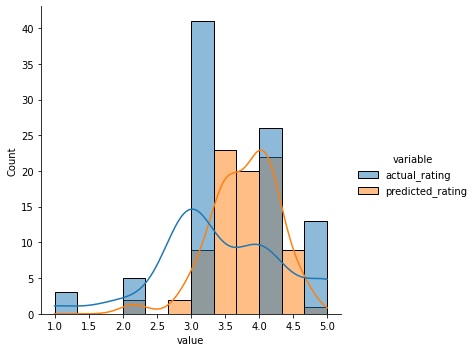

In [213]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, similarity_algo_optimized_item)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

The system predicts a higher value of recommendation of 4 whereas the user rates only around 3

Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `userId=7`

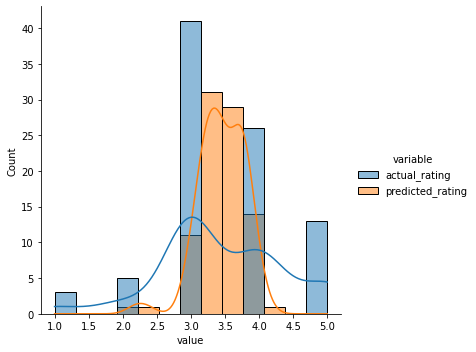

In [214]:
predicted_ratings_for_interacted_movies = predict_already_interacted_ratings(rating, 7, svd_algo_optimized)
df = predicted_ratings_for_interacted_movies.melt(id_vars='movieId', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=df, x='value', hue='variable', kde=True);

In [215]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# Loading the rating dataset
data = Dataset.load_from_df(rating[['userId', 'movieId', 'rating']], reader)

# Splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

###  precision and recall, for each of the 6 models, at k = 5 and 10. This is 6 x 2 = 12 numerical values

In [221]:
# Function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [223]:
# A basic cross-validation iterator.
kf = KFold(n_splits=5)

# Make list of k values
K = [5, 10]

# Remove _______ and complete the code
# Make list of models
models = [algo_knn_user, algo_knn_item, algo_svd, svd_algo_optimized ]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.769
-----> Recall:  0.412
> k=5, model=KNNBasic
-----> Precision:  0.64
-----> Recall:  0.332
> k=5, model=SVD
-----> Precision:  0.749
-----> Recall:  0.381
> k=5, model=SVD
-----> Precision:  0.745
-----> Recall:  0.383
> k=10, model=KNNBasic
-----> Precision:  0.75
-----> Recall:  0.549
> k=10, model=KNNBasic
-----> Precision:  0.637
-----> Recall:  0.475
> k=10, model=SVD
-----> Precision:  0.732
-----> Recall:  0.519
> k=10, model=SVD
-----> Precision:  0.739
-----> Recall:  0.529
